# Ordinal Pattern Analysis on Market Data
---


## Running this code:
This code is written in Julia which is not commonplace so I decided to include a guide on how to run this code.
### 1) Install Julia via the link below:
[official download page](https://julialang.org/downloads/)

### 2) Install vscode and the appropriate extensions:
[vscode download](https://code.visualstudio.com/download)
In the vscode extensions tab, add the official Julia extension and the official jupyter notebooks extension.

### 3) Add the necessary packages:
Within vscode, open julia by pressing "alt/option + J" then "alt/option + O". 
Then within the terminal press "]" to enter the package mode. Here type the following to add the dependencies:
```
add CSV, DataFrames, Plots, StatsPlots, Bijections, Combinatorics
```
### 4) Running the notebook blocks
After the dependencies are installed, open the notebook in vscode, then select the kernel as "Julia release channel". Now the code should be able to be executed.
<br>
I apologize for the inconvinence, all the plots and results are available in this file and are completely reproducible.

---

## Algorithm Explanation
Most of the code is located in the file OrdinalPatterns.jl as a module. The code explanation is commented there too but I will explain the algorithm used here too. <br>
### Fast Ordinal Pattern Calculation:
```Julia
function rank_array(array::Vector) #function that ranks the elements of an array by size in an ascending order (If elements are repeated they are given consecutive ranks)
    #sortperm(array) gives the indices with which our array would be sorted (argsort() in numpy)
    #By calling the above function twice, an array of elements ranks is derived (we substract one from all elements of the rank so they start at 0)
    return sortperm(sortperm(array)).-1
end
```
This function uses the fact that ordinal patterns are equivalent to ranking the size of the elements of the array from small to large (example:) <br>
starting array for d=4: [1, 12, 2, 3] -> resulting array: [0, 3, 1, 2] <br>
This can be acheived by running the sortperm() (equivalent to argsort() in numpy) function twice. Sortperm() return the order of which elements should be called for the array to be sorted.<br>
By calling this function twice, we will acheive a ranked array (example:) <br>
starting array for d=4: [1, 12, 2, 3] -> first sortperm() call: [0, 2, 3, 1] -> second sortperm() call: [0, 3, 1, 2] <br>
This allows us to generate the ordinal pattern of an array with time complexity $O(d \log d)$ <br>

### Fast Mapping of Ordinal Patterns:
```Julia
function ordinal_pattern_map(d::Int) #function that creates a bidirectional map between the permutations of arrays of degree d and a unique number
    map = Bijection{Int, Vector}() #creates a bidirectional map between an Int and a Vector
    #Creates all possible permutations of the ordinal pattern of degree d and puts it in the array possibilities
    init_array = Int[] 
    for i in 1:d
        push!(init_array, i-1)
    end
    possibilities = collect(permutations(init_array, d))
    #A map is created assigining a unique number to each possible ordinal pattern for degree d
    for i in 1:factorial(d)
        map[i] = possibilities[i]
    end
    return map
end
```
The goal of this function is to generate a one to one map of each possible ordinal pattern to a unique number so conversions between the two could be done quickly.<br>
To acheive this I used a package called Bijections.jl which creates a one to one hashmap between a number and an array which represents the ordinal pattern. <br>
Then all possible permutations of the array [1, 2, ..., d] is calculated using the Combinatorics.jl package which gives us all possible ordinal patterns of degree d. <br>
Finally all these combinations are added to the bijection map. The lookup time complexity in both directions will therefore be $O(1)$ which is great.

### Generating the ordinal pattern
```Julia
function generate_ordinal_pattern(array::Vector, d::Int) #function that takes an array and the degree as input and returns an array of numbers representing the ordinal pattern
    num = length(array) - d + 1 #d-1 elements are lost
    new_array = zeros(Int,length(array)) 
    map = ordinal_pattern_map(d)
    #The loop selects a data window of size d from the initial array, then ranks the elements and finally matches it to the corresponding ordinal pattern number using the map
    #The indexes of the new data array where data is lost will remain zero to not disturb the timeseries
    for i in 1:num
        new_array[i+d-1] = map(rank_array(array[i:i+d-1]))
    end
    return new_array
end
```
This function simply goes over the input array and computes the ordinal pattern of a window of size $d$. Then it returns an array of the ordinal pattern numbers.

### Calculating the probability matrix
```Julia
function correlation_probability_matrix(array::Vector, d::Int) #function that creates a probability of correlation matrix between two consecutive patterns
    total_possible = factorial(d)
    mat = zeros(total_possible,total_possible)
    num = length(array)
    for i in 1:num-1
        mat[array[i], array[i+1]] += 1
    end
    return mat./(num-1)
end
```
The correlation probability matrix shows the probability of a certain ordinal pattern to appear after the previous. This function compares two consecutive elements <br>
of the ordinal pattern array and adds one to the corresponding element of the matrix. Then the matrix is normalized to calculate the probabilities.



---

## Expected Results

throughout this document, the following items will be calculated:
- The ordinal patterns array
- Histogram of ordinal patterns
- Correlation Probability matrix of the ordinal patterns (including heatmap) 
<br>
These calculations will be done for the price row of the gold data both with and without the moving average window and for d=3 upto d=7 <br>
The same calculations will be done for test2.txt without a window and for d=3 upto d=6 <br>

### Note
- Some heatmaps where the probabilities are sparse and small, the logarithm of the probabilities are plotted
- I added the label 'P' to the price column of the data
- The data is not included in this rar file and the file paths must be changed for this code to work

---
## Finding the appropriate window size

In order to eliminate some noise from our data we can use the method of moving averages discussed in class and the R code we where given. <br>
Running the code for a window size of 1 results in the following M1 and M2 graphs. <br> <br>
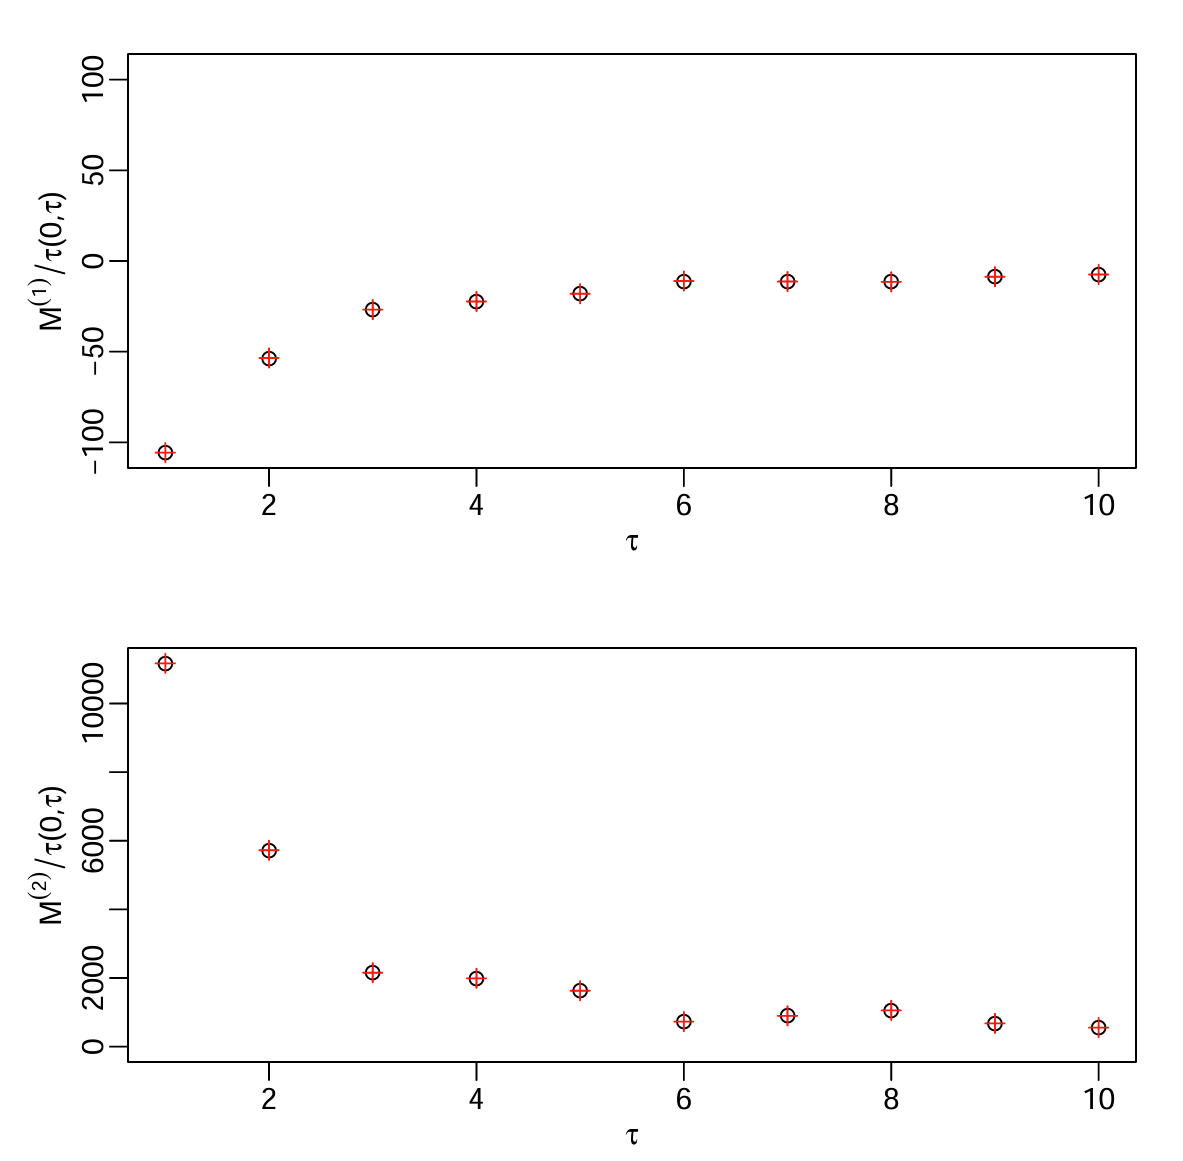
<br>
We can clearly see that the M2 graph shows a $M_2 \alpha \frac{1}{\tau}$ relationship that means noise is dominant. <br>
When we apply a window size of around 10 which means 10 minute windows we see the following graphs
<br> <br>
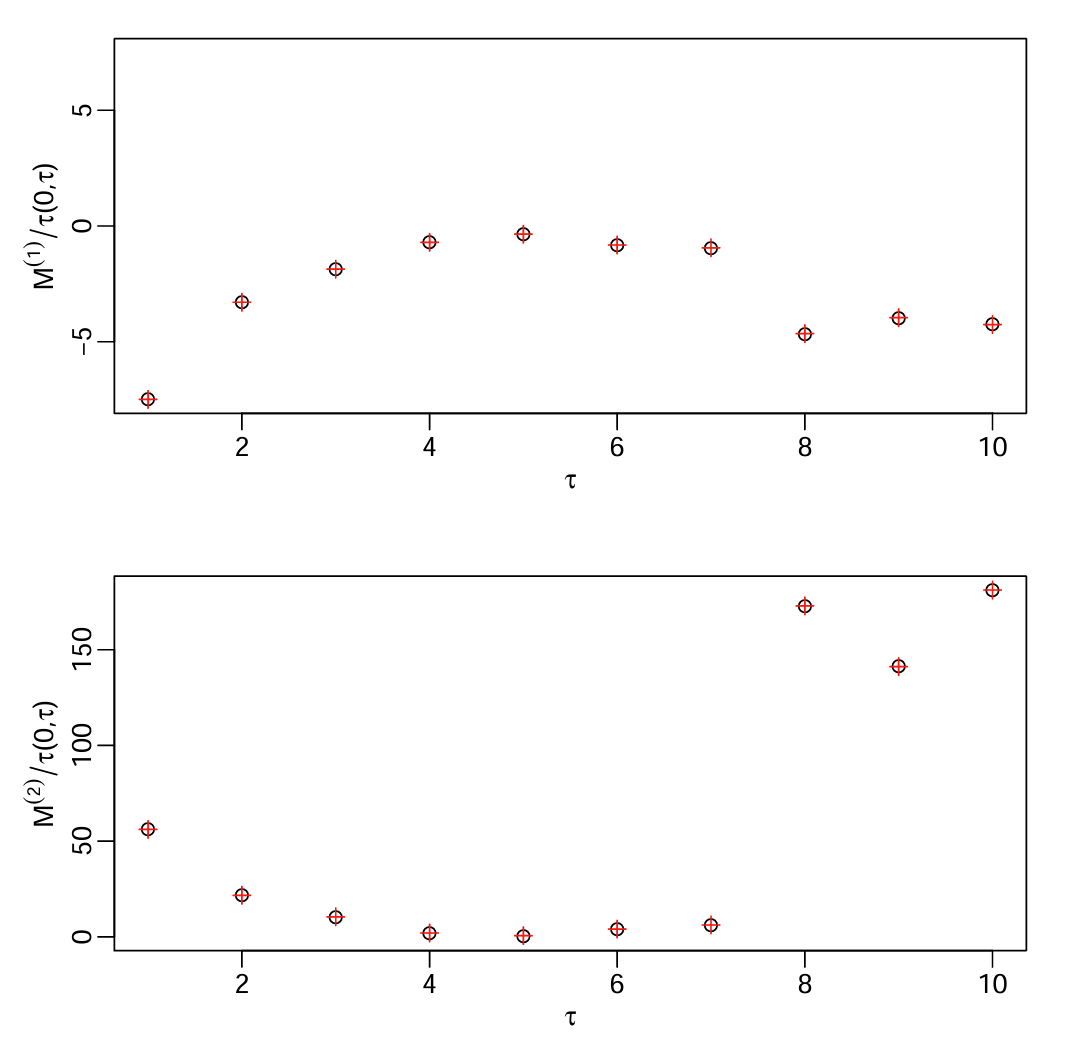
<br>
Now the $\frac{1}{\tau}$ relationship has disappeared and noise is no longer dominant so we will use a 10 minute window in the gold data with moving average segment.

---

## Executing the code and results

Package imports:

In [1]:
include("./OrdinalPatterns.jl")
import .OrdinalPatterns as OP
using CSV, DataFrames, StatsPlots

Define function for calculating the moving average.

In [ ]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

## Gold Data Ordinal Patterns
---
Opening the price data without applying a moving average (the data columns are given headers "P" and "Q" which the "P" header is the price)

In [1]:
#Change the path below to the Gold.txt file and also add a header 'P' to the price column for the code to work
GoldData = CSV.read("GOLD_dt=0.01666/Abolfazl_0.01666.txt", DataFrame, delim = " ") 
Price = GoldData.P

### Ordinal pattern distribution and correlation probability heatmap
d = 3

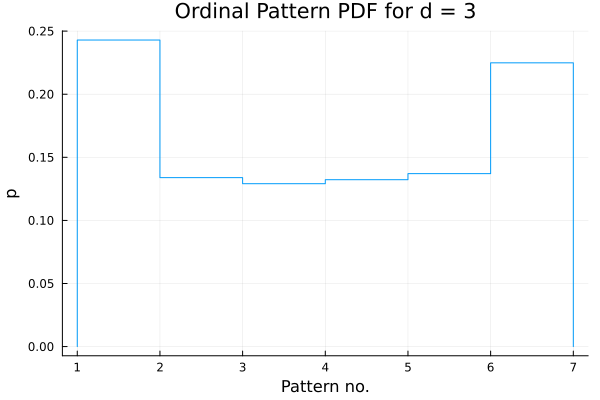

In [11]:
d = 3
goldOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(goldOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

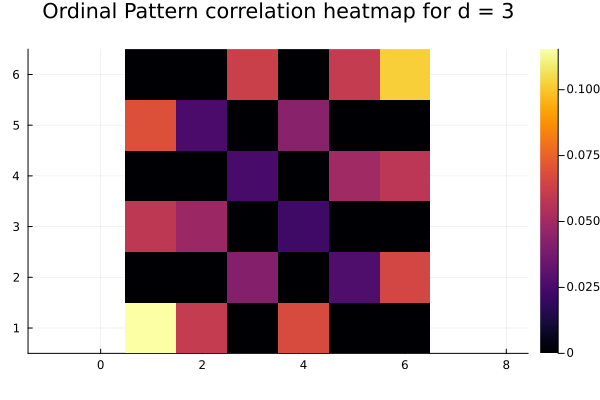

In [12]:
heatmap(OP.correlation_probability_matrix(goldOrdinalArray[d:end], d), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d")

d = 4

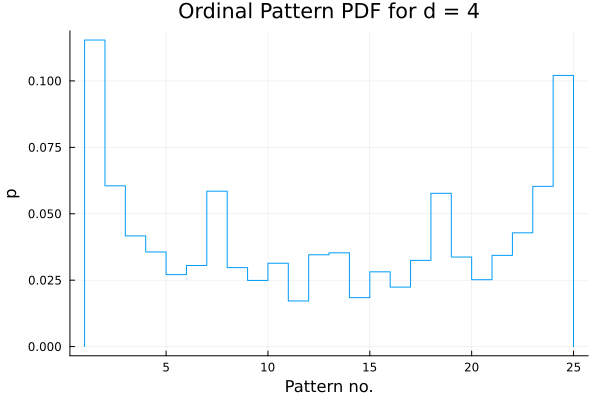

In [13]:
d = 4
goldOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(goldOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

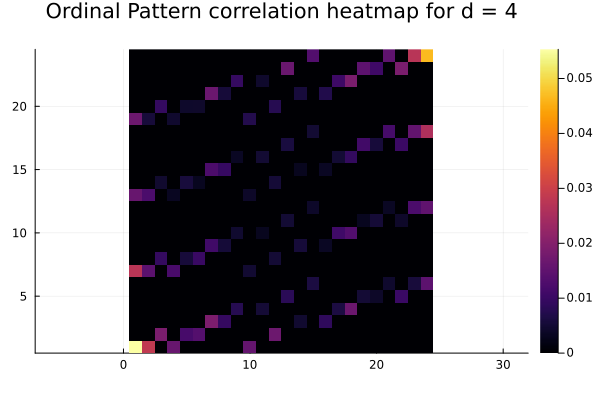

In [14]:
heatmap(OP.correlation_probability_matrix(goldOrdinalArray[d:end], d), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d")

d = 5



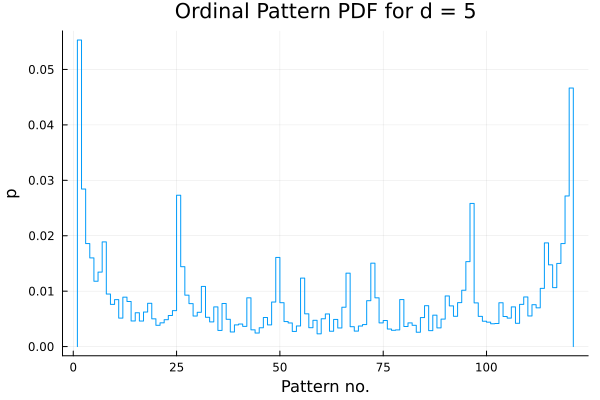

In [15]:
d = 5
goldOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(goldOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

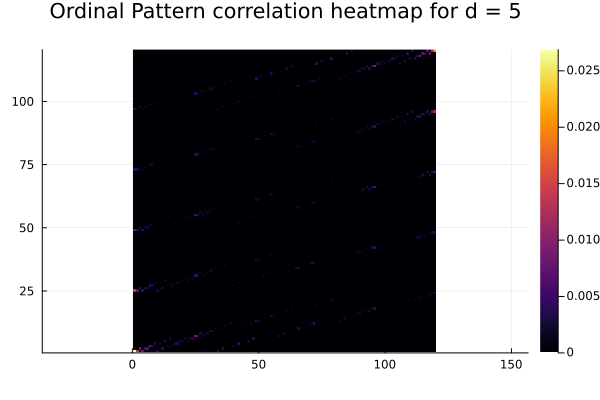

In [17]:
heatmap(OP.correlation_probability_matrix(goldOrdinalArray[d:end], d), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d")

d = 6

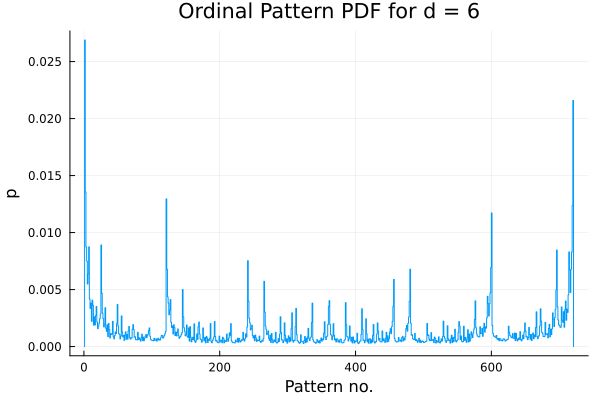

In [18]:
d = 6
goldOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(goldOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

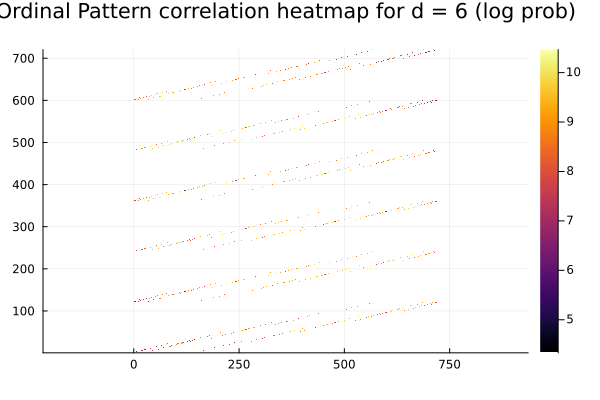

In [23]:
heatmap(-log.(OP.correlation_probability_matrix(goldOrdinalArray[d:end], d)), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d (log prob)")

### Result Analysis
By looking at the histograms for every d, we see that the totally increasing pattern (pattern no. 0) is most common and 
some particular patterns happen most often while others are less common. The heatmaps show that after a 0 pattern, another 0 pattern is most probable and after a totally decreasing pattern, another of the same is most probable. Overall it seems that the distribution and matrix aren't completely symmetrical and there is 
a possibility of finding useful patterns of investment. Overall with the increase of d, the matrix becomes more sparse since more combinations are impossible. But still the resolution of our data seems to increase with the increase of d which might cause more complex patterns to emerge.

---
## Gold Ordinal Paterns after applying a moving average with window size 10

Calculating the moving average

In [ ]:
Price = moving_average(Price, 10)

d = 3

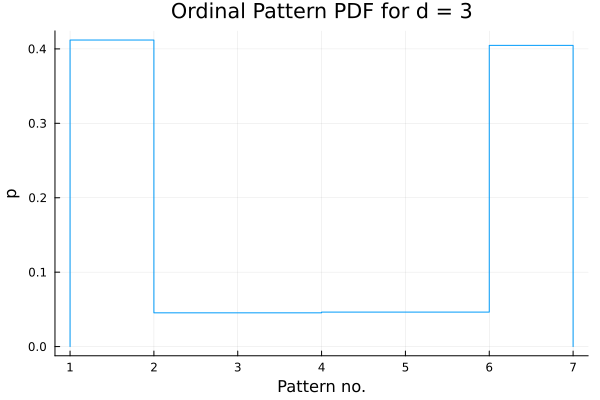

In [26]:
d = 3
goldOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(goldOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

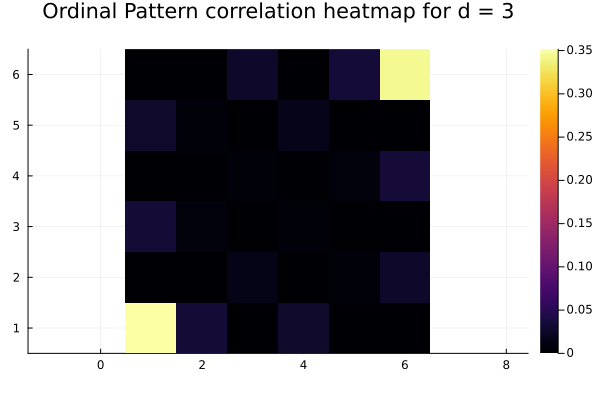

In [27]:
heatmap((OP.correlation_probability_matrix(goldOrdinalArray[d:end], d)), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d")

d = 4

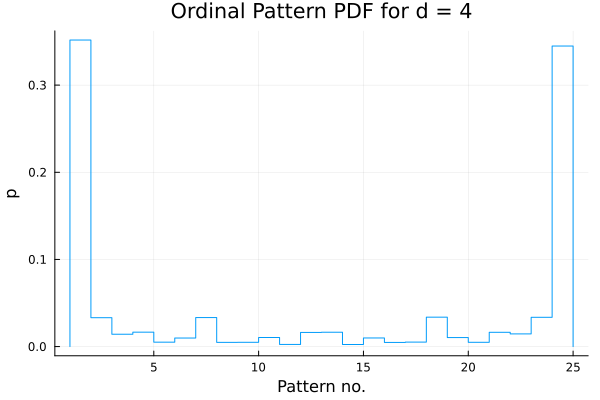

In [28]:
d = 4
goldOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(goldOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

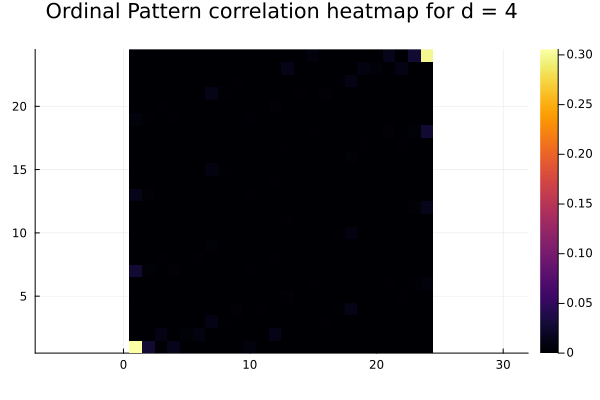

In [29]:
heatmap((OP.correlation_probability_matrix(goldOrdinalArray[d:end], d)), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d")

d = 5

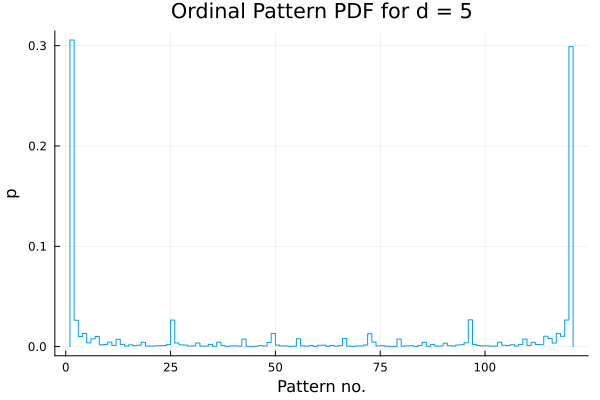

In [30]:
d = 5
goldOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(goldOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

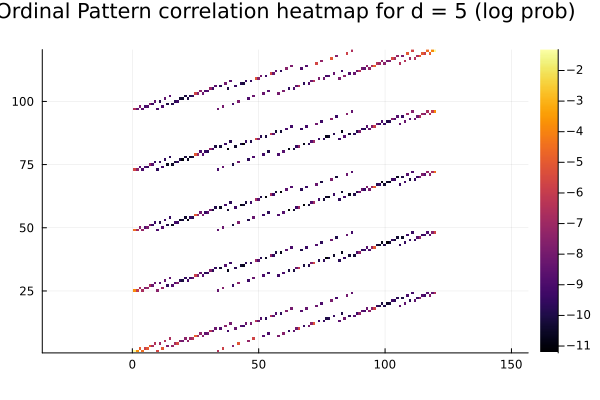

In [31]:
heatmap(log.(OP.correlation_probability_matrix(goldOrdinalArray[d:end], d)), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d (log prob)")

d = 6

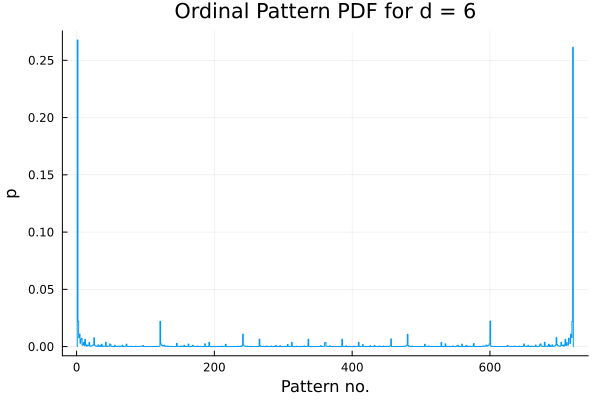

In [32]:
d = 6
goldOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(goldOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

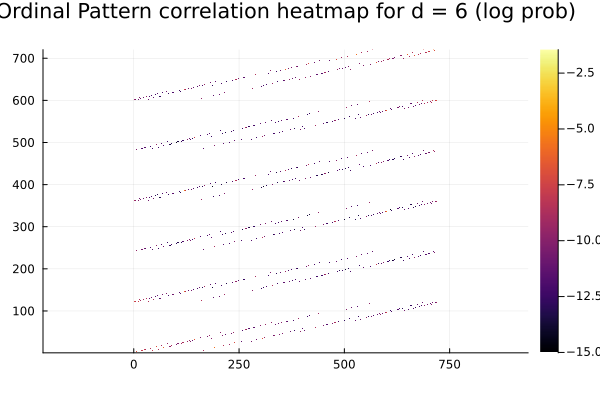

In [33]:
heatmap(log.(OP.correlation_probability_matrix(goldOrdinalArray[d:end], d)), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d (log prob)")

d = 7

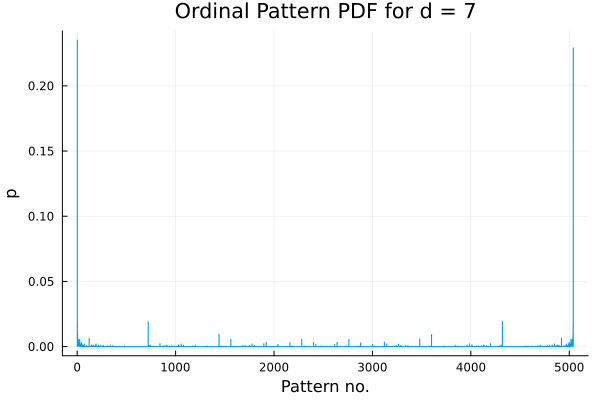

In [34]:
d = 7
goldOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(goldOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

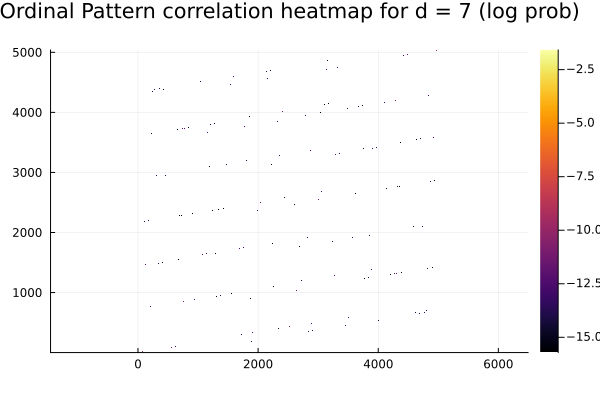

In [35]:
heatmap(log.(OP.correlation_probability_matrix(goldOrdinalArray[d:end], d)), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d (log prob)")

### Result Analysis
Throughout all 'd's we see a decrease in the variety of ordinal patterns after applying a window which is expected. Still we can see that some patterns are alot more common than others and the totally increasing pattern is more common than the totally decreasing one and the lack of complete symmetry still exists.

## Test 2 Ordinal Patterns
---
Reading the data

In [ ]:
#Replace the path below with the path of the test2.txt file and add the header 'P' to the column for the code to work
Test2Data = CSV.read("test2.txt", DataFrame, delim = " ")
Price = Test2Data.P

d = 3

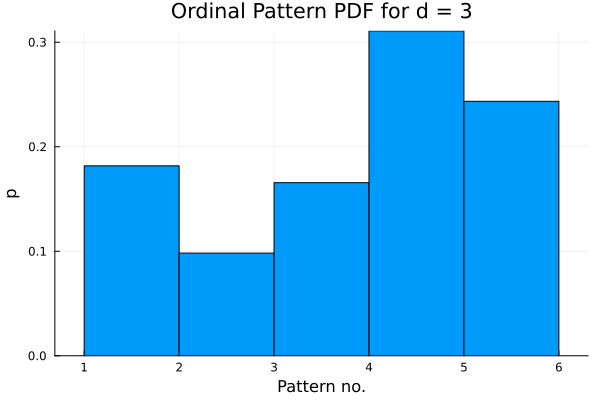

In [40]:
d = 3
testOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(testOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

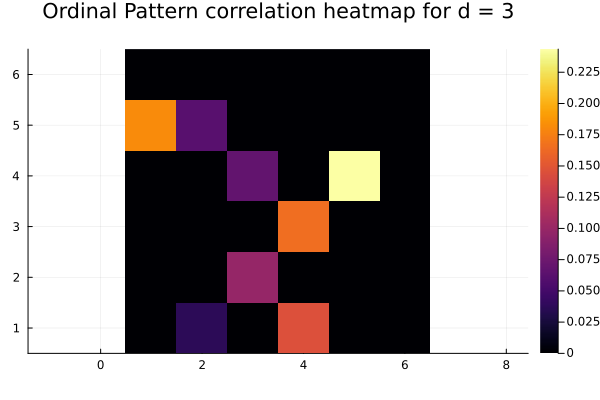

In [41]:
heatmap(OP.correlation_probability_matrix(testOrdinalArray[d:end], d), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d")

d = 4

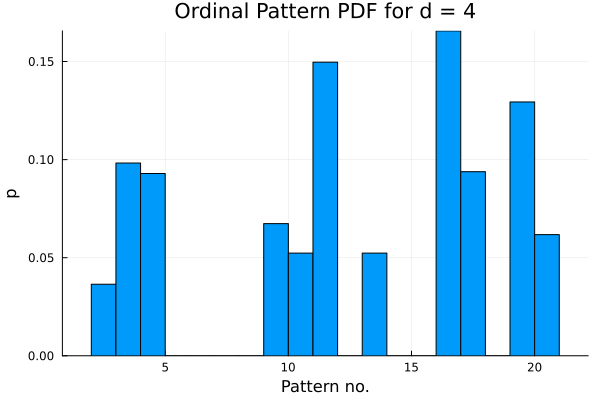

In [42]:
d = 4
testOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(testOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

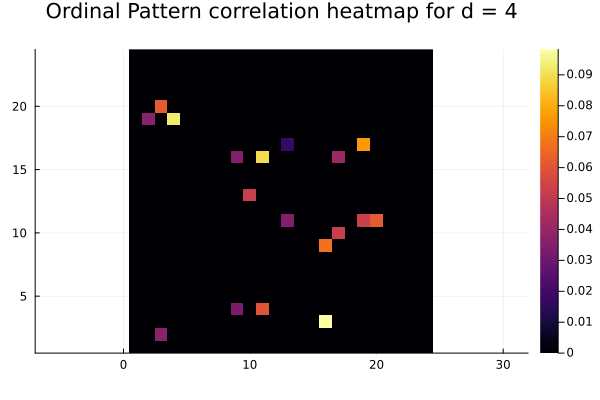

In [43]:
heatmap(OP.correlation_probability_matrix(testOrdinalArray[d:end], d), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d")

d = 5

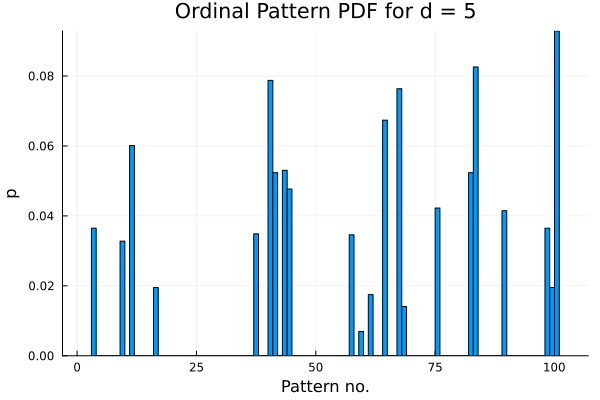

In [44]:
d = 5
testOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(testOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

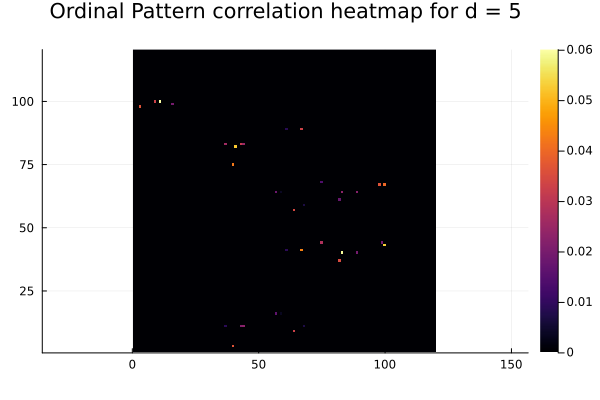

In [45]:
heatmap(OP.correlation_probability_matrix(testOrdinalArray[d:end], d), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d")

d = 6

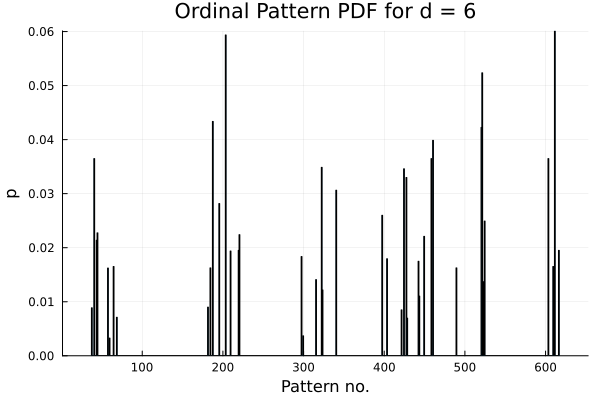

In [46]:
d = 6
testOrdinalArray = OP.generate_ordinal_pattern(Price, d)
histogram(testOrdinalArray[d:end], bins = factorial(d), normalize = :pdf, title = "Ordinal Pattern PDF for d = $d", legend = false, xlabel = "Pattern no.", ylabel = "p")

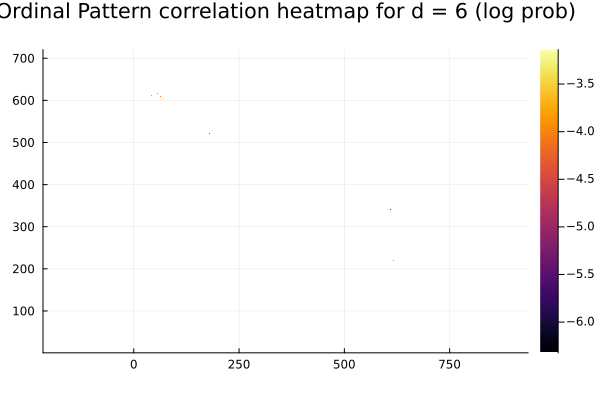

In [48]:
heatmap(log.(OP.correlation_probability_matrix(testOrdinalArray[d:end], d)), aspectratio = 1, title = "Ordinal Pattern correlation heatmap for d = $d (log prob)")

Data exists in the plot above but the matrix is too sparse to see

### Result Analysis
We can see that this data is special and has a really low amont of randomness since only some of the ordinal patterns exist and the others just don't. In the Matrices 
we can also see that there are hotspots and the data lacks symmetry which makes making good predictions highly likely. With the increase of d we also see that as expected the matrix gets more and more sparse and more complex patterns emerge but still the overall structure remains similar.

---
## Conclusion

Throughout the report we can see that ordinal patterns provide an insight into how a market performs and it's skewed properties. It can also potentially allow us to make some albeit small predictions for future investments. <br>

### Extras that can be done:
After all we have done, we can use the probability matrices to find patterns that result in an increasing ordinal pattern. Then we can use the resulting matrix to give a percentage of success to buying or selling after every ordinal pattern and create a simple prediction model. Then we can use the ROC curve to find the best threshold for our model and improve it. <br>
Other things we can do is to use the ordinal patterns array to calculate a power spectrum and potentially find some longer range correlation between the ordinal patterns and gain more insight into our data.